# day-08 低阶API示例

In [1]:
import tensorflow as tf

# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp() % (24 * 60 * 60)
    hour = tf.cast(today_ts // 3600 + 8, tf.int32) % tf.constant(24)
    minite = tf.cast((today_ts % 3600) // 60, tf.int32)
    second = tf.cast(tf.floor(today_ts % 60), tf.int32)

    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}", m)) == 1:
            return (tf.strings.format("0{}", m))
        else:
            return (tf.strings.format("{}", m))

    timestring = tf.strings.join([timeformat(hour), timeformat(minite), timeformat(second)], separator=":")
    tf.print("=============" * 8 + timestring)

一、线性回归模型

In [2]:
# 1.准备数据
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

# 样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n, 2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n, 1], mean=0.0, stddev=2.0)      # @表示矩阵乘法，增加正态扰动

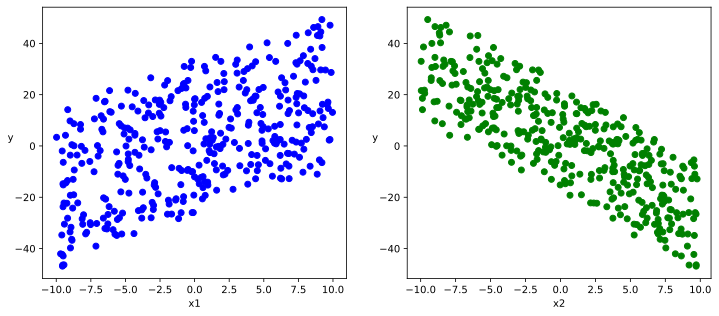

In [3]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = "svg"

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c="b")
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c="g")
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
plt.show()

In [5]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)      # 使得样本读取顺序随机
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i+batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)

# 测试数据管道效果
batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 8.8744049e+00 -5.9101176e+00]
 [ 5.7756233e+00  3.9274902e+00]
 [-6.2770844e-03  4.5847626e+00]
 [ 4.5152779e+00  5.8706427e+00]
 [ 9.0628319e+00  2.8971119e+00]
 [ 4.1219854e+00  5.3337574e+00]
 [ 7.3405819e+00  6.6633892e+00]
 [-7.7999067e+00  6.9368725e+00]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 43.07831  ]
 [  1.0953481]
 [-12.031451 ]
 [ -3.692919 ]
 [ 13.651146 ]
 [ -3.3513076]
 [  1.5156233]
 [-33.65699  ]], shape=(8, 1), dtype=float32)


In [9]:
# 定义模型
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0, dtype=tf.float32))

class LinearRegression:
    # 正向传播
    def __call__(self, x):
        return x@w + b

    # 损失函数
    def loss_func(self, y_true, y_pred):
        return tf.reduce_mean((y_true - y_pred)**2 / 2)

model = LinearRegression()

In [10]:
# 训练模型
# 使用动态图调试
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)

    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # 梯度下降法更新参数
    w.assign(w - 0.001 * dloss_dw)
    b.assign(b - 0.001 * dloss_db)

    return loss

In [11]:
# 测试train_step效果
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=106.47795>

In [12]:
def train_model(model, epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)

        if epoch % 50 == 0:
            printbar()
            tf.print("epoch =", epoch, "loss =", loss)
            tf.print("w =", w)
            tf.print("b =", b)

train_model(model, epochs=200)

========================================================================================================16:23:39
epoch = 50 loss = 1.63679159
w = [[1.9873184]
 [-2.97521782]]
b = [[2.69330502]]
========================================================================================================16:23:51
epoch = 100 loss = 2.53485751
w = [[1.99003065]
 [-2.98054647]]
b = [[3.06459785]]
========================================================================================================16:24:03
epoch = 150 loss = 2.38859487
w = [[1.99515772]
 [-2.98394108]]
b = [[3.11449075]]
========================================================================================================16:24:16
epoch = 200 loss = 2.33801126
w = [[1.98775649]
 [-2.98306155]]
b = [[3.12169266]]


In [13]:
# 使用autograph机制加速
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w,b])

    # 梯度下降法更新参数
    w.assign(w - 0.001 * dloss_dw)
    b.assign(b - 0.001 * dloss_db)

    return loss

def train_model(model, epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)
        if epoch % 50 == 0:
            printbar()
            tf.print("epoch =", epoch, "loss =", loss)
            tf.print("w =", w)
            tf.print("b =", b)

train_model(model, epochs=200)

========================================================================================================16:29:07
epoch = 50 loss = 1.46863961
w = [[1.99197114]
 [-2.98618388]]
b = [[3.12257171]]
========================================================================================================16:29:15
epoch = 100 loss = 2.22569323
w = [[1.99576712]
 [-2.98403645]]
b = [[3.12272525]]
========================================================================================================16:29:23
epoch = 150 loss = 0.898977637
w = [[1.99429607]
 [-2.98168206]]
b = [[3.12291193]]
========================================================================================================16:29:31
epoch = 200 loss = 1.08236
w = [[1.98982549]
 [-2.98377156]]
b = [[3.12353373]]


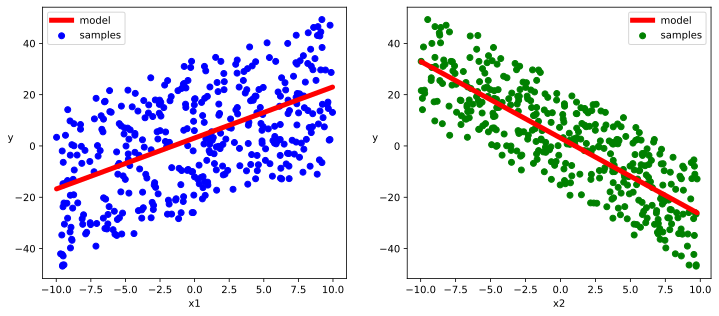

In [14]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format="svg"

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c="b", label="samples")
ax1.plot(X[:, 0], w[0] * X[:, 0] + b[0], "-r", linewidth=5.0, label="model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c="g", label="samples")
ax2.plot(X[:, 1], w[1] * X[:, 1] + b[0], "-r", linewidth=5.0, label="model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

二、DNN二分类模型

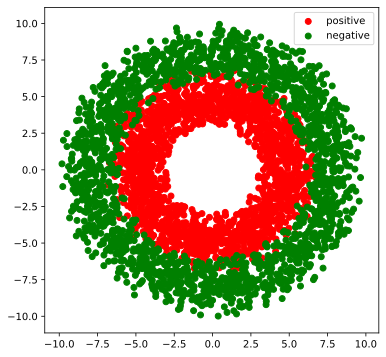

In [15]:
# 准备数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format="svg"

# 正负样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本，小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive, 1], 0.0, 1.0)
theta_p = tf.random.uniform([n_positive, 1], 0.0, 2 * np.pi)
Xp = tf.concat([r_p * tf.cos(theta_p), r_p * tf.sin(theta_p)], axis=1)
Yp = tf.ones_like(r_p)

# 生成负样本，大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative, 1], 0.0, 1.0)
theta_n = tf.random.uniform([n_negative, 1], 0.0, 2 * np.pi)
Xn = tf.concat([r_n * tf.cos(theta_n), r_n * tf.sin(theta_n)], axis=1)
Yn = tf.zeros_like(r_n)

# 汇总样本
X = tf.concat([Xp, Xn], axis=0)
Y = tf.concat([Yp, Yn], axis=0)

# 可视化
plt.figure(figsize=(6,6))
plt.scatter(Xp[:,0].numpy(), Xp[:,1].numpy(), c="r")
plt.scatter(Xn[:,0].numpy(), Xn[:,1].numpy(), c="g")
plt.legend(["positive", "negative"])

In [16]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = indices[i:min(i+batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)

# 测试数据管道效果
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tf.Tensor(
[[-1.5222417   6.9388146 ]
 [ 1.3478198  -6.16959   ]
 [ 2.489982   -4.312914  ]
 [-2.302971    5.027046  ]
 [ 5.0404406   6.802742  ]
 [-0.86107117  6.622599  ]
 [ 3.6033628  -2.3746119 ]
 [ 1.4986213  -7.8807034 ]
 [ 3.235583    3.1539607 ]
 [-6.4145064  -4.6421905 ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]], shape=(10, 1), dtype=float32)


In [17]:
# 定义模型
# 利用tf.Module来组织模型变量
class DNNModel(tf.Module):
    def __init__(self, name=None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]), dtype=tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]), dtype=tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]), dtype=tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]), dtype=tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]), dtype=tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]), dtype=tf.float32)

    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
    def __call__(self, x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y

    # 损失函数（二元交叉熵）
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,1], dtype=tf.float32), tf.TensorSpec(shape=[None,1], dtype=tf.float32)])
    def loss_func(self, y_true, y_pred):
        # 将预测值限制在1e-7以上，1-1e-7以下
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(bce)

    # 评估指标（准确率）
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,1], dtype=tf.float32), tf.TensorSpec(shape=[None,1], dtype=tf.float32)])
    def metric_func(self, y_true, y_pred):
        y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred, dtype=tf.float32), tf.zeros_like(y_pred, dtype=tf.float32))
        acc = tf.reduce_mean(1 - tf.abs(y_true - y_pred))
        return acc

model = DNNModel()

In [18]:
# 测试模型结构
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))

predictions = model(features)

loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)

tf.print("init loss: ", loss)
tf.print("init metric: ", metric)

init loss:  4.44314957
init metric:  0.6


In [19]:
print(len(model.trainable_variables))

6


In [20]:
# 3.训练模型
@tf.function
def train_step(model, features, labels):
    # 正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)

    # 反向传播求梯度
    grads = tape.gradient(loss, model.trainable_variables)

    # 执行梯度下降
    for p, dloss_dp in zip(model.trainable_variables, grads):
        p.assign(p - 0.001 * dloss_dp)

    # 计算评估指标
    metric = model.metric_func(labels, predictions)

    return loss, metric

def train_model(model, epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 100):
            loss, metric = train_step(model, features, labels)
        if epoch % 100 == 0:
            printbar()
            tf.print("epoch =", epoch, "loss =", loss, "accuracy =", metric)

train_model(model, epochs=600)

========================================================================================================17:09:03
epoch = 100 loss = 0.542164505 accuracy = 0.72
========================================================================================================17:09:20
epoch = 200 loss = 0.437875867 accuracy = 0.79
========================================================================================================17:09:38
epoch = 300 loss = 0.438687027 accuracy = 0.7
========================================================================================================17:09:55
epoch = 400 loss = 0.282871664 accuracy = 0.88
========================================================================================================17:10:13
epoch = 500 loss = 0.2717143 accuracy = 0.91
========================================================================================================17:10:30
epoch = 600 loss = 0.187628061 accuracy = 0.92


Text(0.5, 1.0, 'y_pred')

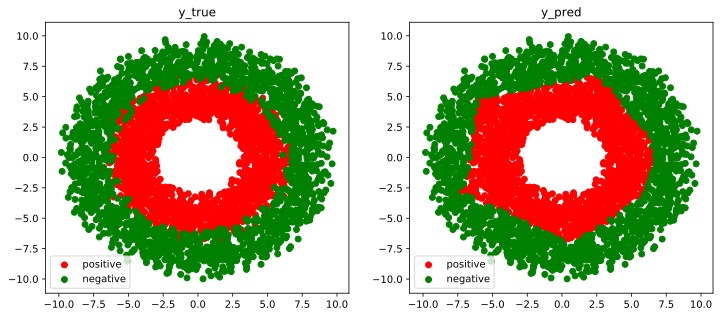

In [21]:
# 结果可视化
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.scatter(Xp[:,0], Xp[:,1], c="r")
ax1.scatter(Xn[:,0], Xn[:,1], c="g")
ax1.legend(["positive", "negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"])
ax2.set_title("y_pred")